### Exercise 2.4
Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the q*(a) start out equal and then take independent random walks (say by adding a normally distribured increment with mean zero and standard deviation 0.01 to all the q*(a) on each step). Prepare plots like Figure 2.2 for an action-value method using smaple averages, incrementally computed, and another action-value method using a constant step-size parameter, alpha = 0.1, use e=0.1 and longer runs, say of 10000 steps

### Creating k-Armed Bandit

In [377]:
import random
import numpy as np

class Bandit():
    def __init__(self, k, reward_mean=0, manual_step=False):
        self.k = k                                   # Number of bandits
        self.k_rewards = np.zeros(k) + reward_mean   # Reward buffer with specified mean
        self.manual_step = manual_step      # Whether to step manually after reward (used for sharing with agents)   

    def get_optimal_action(self):
        return np.argmax(self.k_rewards)

    def step(self):
        self.k_rewards += np.random.uniform(-0.018, 0.018, size=self.k)   # Approximate stdev of 0.01
    
    def reward(self, action_k):
        to_return = self.k_rewards[action_k]
        if not self.manual_step:
            self.step()
        return to_return

class Agent():
    def __init__(self,
                 bandit,
                 action_value="ave",
                 action_selection="greedy",
                 step_size=0.1,
                 epsilon=0.1,
                 c=0.1,
                 action_activation="sigmoid",
                 est_reward=None):
        self.bandit = bandit                   # bandit to learn
        self.k = bandit.k                      # k derived from the bandit
        self.indices = range(bandit.k)
        self.action_value = action_value       # type of action value. supports "ave", "inc"
        self.action_selection = action_selection # type of action selection. supports "greedy", "ubc", "gradient"
        self.step_size = step_size             # decay rate
        self.epsilon = epsilon                 # exploration weight
        self.c = c
        self.t = 0                             # time increment
        
        self.action_counter = np.zeros(bandit.k)    # counts number of times action k is selected
        self.est_reward = np.zeros(bandit.k)        # estimated rewards for all k actions
        if est_reward:
            self.est_reward += est_reward

        self.action_activation = action_activation
        self.action_proba = np.zeros(bandit.k)
        
        
        # METRICS
        self.optimal_actions = 0
        self.average_reward = 0
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    def softmax(X, i):
        return np.exp(X[i]) / np.sum(np.exp(X))
    
    def step(self):
        # Increment time-step
        self.t += 1
        
        if self.action_selection == "greedy":
            # Chooses random action if r < epsilon
            if random.uniform(0, 1) < self.epsilon:
                action_k = random.randint(0, self.k - 1)
            else:
                action_k = np.argmax(self.est_reward)
        elif self.action_selection == "ubc":
            # Upper bound confidence
            def ubc(i):
                if self.action_counter[i] == 0:
                    return np.inf
                else:
                    return self.est_reward[i] + (self.c * np.sqrt(np.log(self.t) / self.action_counter[i]))
            action_k = np.argmax([ubc(i) for i in range(self.k)])
        elif self.action_selection == "gradient":
            # Calculate probabilities of all actions using respective activation
            if self.action_activation == "sigmoid":
                self.action_proba = [Agent.sigmoid(self.est_reward[i]) for i in self.indices]
                self.action_proba /= np.sum(self.action_proba)
            elif self.action_activation == "softmax":
                self.action_proba = [Agent.softmax(self.est_reward, i) for i in self.indices]
            # Choose action based on probabilities
            action_k = np.random.choice(self.indices, p=self.action_proba)
            
        # Increments action count
        self.action_counter[action_k] += 1
        
        # Keeps running tab on optimal action count
        self.optimal_actions += (action_k == self.bandit.get_optimal_action())
        
        # Take a single step, recieve reward
        reward = self.bandit.reward(action_k)
        
        # Compute running average reward
        self.average_reward = ((self.average_reward * (self.t - 1)) + reward) / self.t
        
        # If using gradient, update preference using stochastic gradient ascent
        if self.action_selection == "gradient":
            one_hot = np.zeros(self.k)
            one_hot[action_k] = 1
            self.est_reward += self.step_size * (reward - self.average_reward) * (one_hot - self.action_proba)

        # Update estimated reward based on set action_value
        if self.action_value == "ave":
            self.est_reward[action_k] += ((1. / self.t) * (reward - self.est_reward[action_k]))
        elif self.action_value == "inc":
            self.est_reward[action_k] += (self.step_size * (reward - self.est_reward[action_k]))
    
    def nstep(self, n):
        for i in range(n):
            self.step()

In [378]:
%matplotlib notebook
import matplotlib.pyplot as pp

b = Bandit(k=10, manual_step=True, reward_mean=0)
a_ave = Agent(bandit=b, action_value="inc", action_selection="gradient", action_activation="softmax", step_size=0.1)
a_inc = Agent(bandit=b, action_value="inc", action_selection="gradient", action_activation="softmax", step_size=0.4)

a_ave_optimal = []
a_ave_average = []

a_inc_optimal = []
a_inc_average = []

t_axis = []
t = 0
nstep = 1
for i in range(100000):
    
    a_ave.step()
    a_inc.step()
    b.step()
    
    t += nstep
    t_axis.append(t)
    
    a_ave_optimal.append(a_ave.optimal_actions / t)
    a_ave_average.append(a_ave.average_reward)
    
    a_inc_optimal.append(a_inc.optimal_actions / t)
    a_inc_average.append(a_inc.average_reward)

### Evaluating Incremental vs Average Action Value
It is apparent the incremental action value performs better than average action value. It is able to adapt to the nonstationary reward, whereas average's  estimated reward converges and rarely moves despite the actual rewards moving.

### Evaluating Greedy vs UBC Action Selection
Upper-bound confidence (UBC) performs slightly better than greedy action selection. This is because it has a better estimate of an action's estimation by including variance/uncertainty in the selection.

<IPython.core.display.Javascript object>


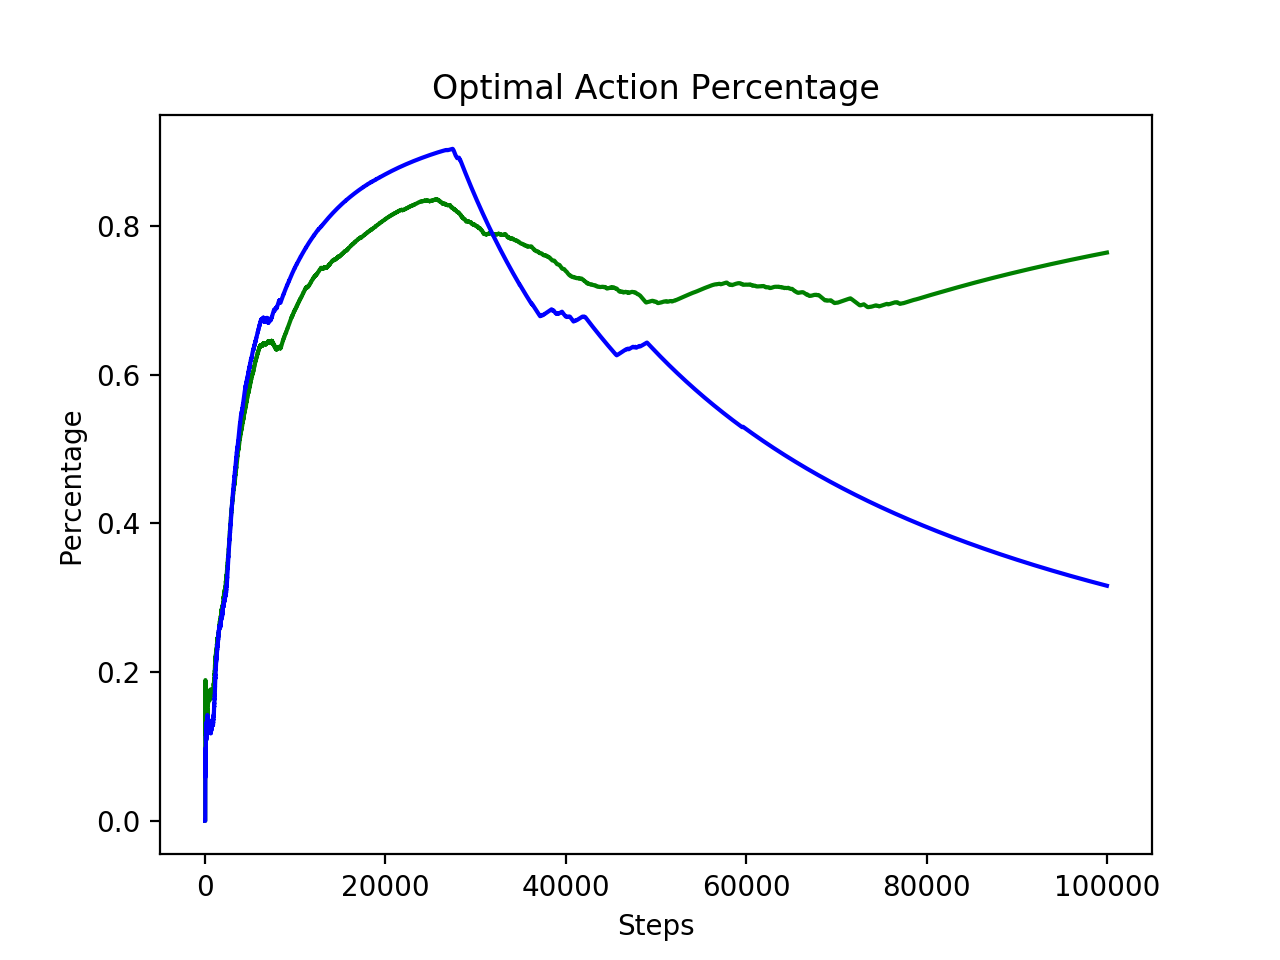

In [379]:
pp.figure(0) # Here's the part I need
pp.title("Optimal Action Percentage")
pp.xlabel("Steps")
pp.ylabel("Percentage")
pp.plot(t_axis, a_ave_optimal, 'g', label='Average')
pp.plot(t_axis, a_inc_optimal, 'b', label='Incremental')

<IPython.core.display.Javascript object>


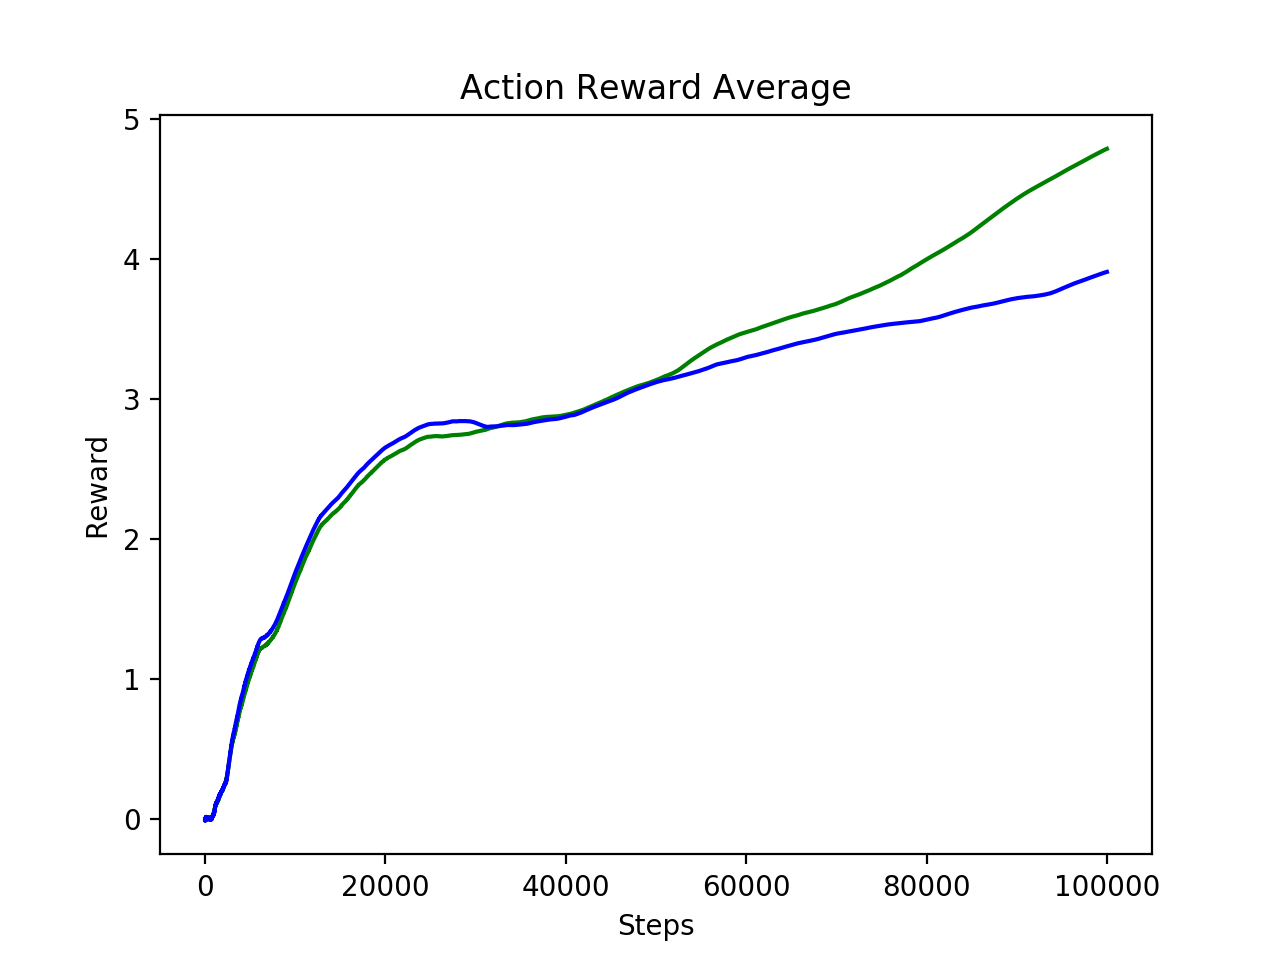

In [380]:
pp.figure(1) # Here's the part I need
pp.title("Action Reward Average")
pp.xlabel("Steps")
pp.ylabel("Reward")
pp.plot(t_axis, a_ave_average, 'g', label='Average')
pp.plot(t_axis, a_inc_average, 'b', label='Incremental')